# Unit Test 2

Topics covered:

* Logistic Regression
* Resampling Methods
* Subset Selection
* Shrinkage Methods

## Background
The study of Near-Earth Objects (NEOs) is critical to ensuring future planetary security from impacts by asteroids. Predicting potential impacts may seem as if it is a straightforward task but the number of variables involved in the process leads to quite a bit of uncertainty. Because of this, the Center for NEO Studies (https://cneos.jpl.nasa.gov/about/cneos.html) and NASA's Jet Propulsion Laboratory has been logging data about asteroids and whether they meet the classification of hazardous or not. The data is provided on Canvas.

### Dataset
`nasa.csv`

## Task
Your goal is to construct a model that effectively predicts whether an asteroid is hazardous or not. Ideally, you will find a relatively simple (i.e. interpretable) model, such that we don't need to collect every variable below to make a prediction (hint: subset selection and/or shrinkage would be useful for this). The fewer variables we have to collect, the more asteroids we'll be able to observe. I would also like you to utilize PCA to select some number of principal components and try a logistic regression with those as predictor variables.

I'm looking for a well-constructed logistic regression, whose assumptions have been checked, with strong cross-validated accuracy and an interpretation of the coefficients. 

In [87]:
import os
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from sklearn.linear_model import RidgeCV
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import mean_squared_error
import datetime as dt
import time
import itertools

cur_dir = Path(os.getcwd()).parent

downloads_path = str(Path.home() / "Downloads")

nasa_df = pd.read_csv('nasa.csv')
nasa_df.reset_index(drop=True, inplace=True)

### Dropping Redundant Columns (exp: keeping KM dropping M, Miles, Feet)

nasa_df = nasa_df[['Name', 'Absolute Magnitude', 'Est Dia in KM(min)', 'Est Dia in KM(max)', 'Epoch Date Close Approach', 'Relative Velocity km per hr', 'Miss Dist.(kilometers)', 'Orbit ID', 'Orbit Determination Date', 'Orbit Uncertainity', 'Minimum Orbit Intersection', 'Jupiter Tisserand Invariant', 'Epoch Osculation', 'Eccentricity',	'Semi Major Axis',	'Inclination', 'Asc Node Longitude',	'Orbital Period', 'Perihelion Distance', 'Perihelion Arg',	'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly', 'Mean Motion', 'Hazardous']]

nasa_df.columns = [re.sub(r'\W+', '', column.replace(' ', '_').lower()) for column in nasa_df.columns]
nasa_df.columns = [re.sub(r'(?<![a-zA-Z])_|_(?![a-zA-Z])', '', column) for column in nasa_df.columns]

nasa_df.rename(columns={
    'est_dia_in_kmmin': 'est_dia_in_km(min)',
    'est_dia_in_kmmax': 'est_dia_in_km(max)'
}, inplace=True)

nasa_df['epoch_orbit_determination_date'] = pd.to_datetime(nasa_df['orbit_determination_date']).apply(lambda x: int(x.timestamp()))
nasa_df['hazardous'] = np.where(nasa_df['hazardous'] == True, 1, 0)

### Train, Test, Validation Df

test_df = nasa_df.sample(frac=0.2, axis=0)
test_df = test_df[['absolute_magnitude', 'est_dia_in_km(max)', 'epoch_date_close_approach',
       'relative_velocity_km_per_hr', 'miss_distkilometers', 'orbit_id',
       'epoch_orbit_determination_date', 'orbit_uncertainity',
       'minimum_orbit_intersection', 'jupiter_tisserand_invariant',
       'epoch_osculation', 'eccentricity', 'semi_major_axis', 'inclination',
       'asc_node_longitude', 'orbital_period', 'perihelion_distance',
       'perihelion_arg', 'aphelion_dist', 'perihelion_time', 'mean_anomaly',
       'mean_motion', 'hazardous']]
train_df = nasa_df.drop(index=test_df.index)
validation_df = nasa_df.copy()

Xtrain = train_df[['absolute_magnitude', 'est_dia_in_km(max)', 'epoch_date_close_approach',
       'relative_velocity_km_per_hr', 'miss_distkilometers', 'orbit_id',
       'epoch_orbit_determination_date', 'orbit_uncertainity',
       'minimum_orbit_intersection', 'jupiter_tisserand_invariant',
       'epoch_osculation', 'eccentricity', 'semi_major_axis', 'inclination',
       'asc_node_longitude', 'orbital_period', 'perihelion_distance',
       'perihelion_arg', 'aphelion_dist', 'perihelion_time', 'mean_anomaly',
       'mean_motion']]

Xtrain = (Xtrain-Xtrain.mean())/Xtrain.std()

print(Xtrain.shape)
#Xtrain = pd.get_dummies(data=Xtrain, drop_first=True)
ytrain = train_df[['hazardous']]
print(ytrain)

corr = (nasa_df[['absolute_magnitude', 'est_dia_in_km(min)',
       'est_dia_in_km(max)', 'epoch_date_close_approach',
       'relative_velocity_km_per_hr', 'miss_distkilometers', 'orbit_id',
       'orbit_determination_date', 'orbit_uncertainity',
       'minimum_orbit_intersection', 'jupiter_tisserand_invariant',
       'epoch_osculation', 'eccentricity', 'semi_major_axis', 'inclination',
       'asc_node_longitude', 'orbital_period', 'perihelion_distance',
       'perihelion_arg', 'aphelion_dist', 'perihelion_time', 'mean_anomaly',
       'mean_motion']]).corr()
corr.style.background_gradient(cmap='RdBu')
#
# fig, ax = plt.subplots()
# sns.heatmap((nasa_df[['absolute_magnitude', 'est_dia_in_km(min)',
#        'est_dia_in_km(max)', 'epoch_date_close_approach',
#        'relative_velocity_km_per_hr', 'miss_distkilometers', 'orbit_id',
#        'orbit_determination_date', 'orbit_uncertainity',
#        'minimum_orbit_intersection', 'jupiter_tisserand_invariant',
#        'epoch_osculation', 'eccentricity', 'semi_major_axis', 'inclination',
#        'asc_node_longitude', 'orbital_period', 'perihelion_distance',
#        'perihelion_arg', 'aphelion_dist', 'perihelion_time', 'mean_anomaly',
#        'mean_motion']]).corr(), annot=True, fmt='.2f',
#             cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
# ax.set_yticklabels(ax.get_yticklabels(), rotation='horizontal')
# plt.savefig('infograph.png', bbox_inches='tight')

(3750, 22)
      hazardous
0             1
1             0
2             1
3             0
4             1
...         ...
4682          0
4683          0
4684          0
4685          0
4686          0

[3750 rows x 1 columns]


,absolute_magnitude,est_dia_in_km(min),est_dia_in_km(max),epoch_date_close_approach,relative_velocity_km_per_hr,miss_distkilometers,orbit_id,orbit_uncertainity,minimum_orbit_intersection,jupiter_tisserand_invariant,epoch_osculation,eccentricity,semi_major_axis,inclination,asc_node_longitude,orbital_period,perihelion_distance,perihelion_arg,aphelion_dist,perihelion_time,mean_anomaly,mean_motion
absolute_magnitude,1.000000,-0.613482,-0.613482,0.168621,-0.376853,-0.339117,-0.575668,0.677764,-0.488235,0.238702,-0.116087,-0.361359,-0.212437,-0.459632,-0.011470,-0.206774,0.086966,0.031784,-0.256169,-0.115855,-0.049401,0.195652
est_dia_in_km(min),-0.613482,1.000000,1.000000,-0.094121,0.242141,0.188027,0.724089,-0.399488,0.257904,-0.133582,0.061582,0.216623,0.121224,0.259450,0.036558,0.118314,-0.071866,-0.019577,0.151836,0.062167,0.031455,-0.104350
est_dia_in_km(max),-0.613482,1.000000,1.000000,-0.094121,0.242141,0.188027,0.724089,-0.399488,0.257904,-0.133582,0.061582,0.216623,0.121224,0.259450,0.036558,0.118314,-0.071866,-0.019577,0.151836,0.062167,0.031455,-0.104350
epoch_date_close_approach,0.168621,-0.094121,-0.094121,1.000000,-0.105725,-0.144807,-0.084657,0.216463,-0.022532,-0.132728,-0.013903,0.007387,0.134480,-0.067337,-0.019341,0.130175,0.131854,0.001834,0.114616,-0.015533,-0.026182,-0.137663
relative_velocity_km_per_hr,-0.376853,0.242141,0.242141,-0.105725,1.000000,0.351694,0.110679,-0.202234,0.076306,-0.052294,0.020194,0.495053,0.014351,0.514657,-0.021301,0.017961,-0.506978,-0.002913,0.144782,0.020006,0.017685,0.022452
miss_distkilometers,-0.339117,0.188027,0.188027,-0.144807,0.351694,1.000000,0.149814,-0.326158,0.351981,0.093969,0.193944,-0.005627,-0.112158,0.255828,-0.023033,-0.109888,-0.079937,-0.021483,-0.103231,0.189409,-0.010157,0.104642
orbit_id,-0.575668,0.724089,0.724089,-0.084657,0.110679,0.149814,1.000000,-0.504578,0.124283,-0.019595,0.036152,0.100314,0.005462,0.112125,0.047959,0.002705,-0.063884,0.001338,0.022269,0.037901,0.048985,-0.008898
orbit_uncertainity,0.677764,-0.399488,-0.399488,0.216463,-0.202234,-0.326158,-0.504578,1.000000,-0.267524,-0.008992,-0.331558,-0.088029,0.043902,-0.228806,-0.009618,0.047535,0.107946,0.016307,0.020908,-0.325784,-0.059396,-0.023776
minimum_orbit_intersection,-0.488235,0.257904,0.257904,-0.022532,0.076306,0.351981,0.124283,-0.267524,1.000000,-0.305849,0.081155,0.093795,0.288947,0.439867,-0.008963,0.279885,0.299991,-0.029130,0.242023,0.080592,-0.013336,-0.290538
jupiter_tisserand_invariant,0.238702,-0.133582,-0.133582,-0.132728,-0.052294,0.093969,-0.019595,-0.008992,-0.305849,1.000000,0.051062,-0.478341,-0.930103,-0.037366,0.018413,-0.893517,-0.537884,0.064496,-0.887879,0.051994,0.030972,0.992680


C:\Users\chance.gunter\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scree Plot')

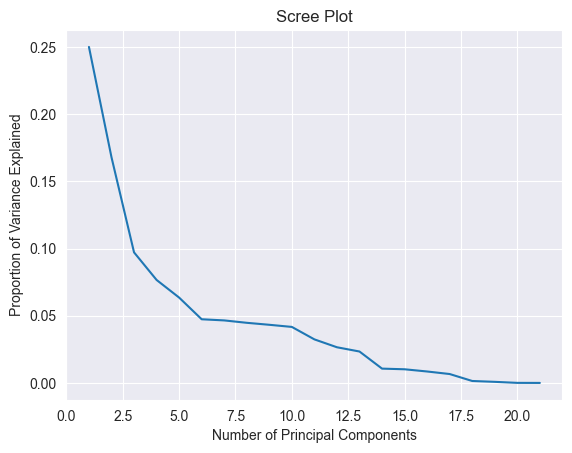

In [88]:
pca = PCA(n_components=Xtrain.shape[1]-1).fit(Xtrain)
pc_train = pca.transform(Xtrain)
sns.lineplot(np.arange(1,Xtrain.shape[1]), pca.explained_variance_ratio_)
plt.xlabel("Number of Principal Components")
plt.ylabel("Proportion of Variance Explained")
plt.title("Scree Plot")

C:\Users\chance.gunter\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Cumulative Proportion of Variance Explained')

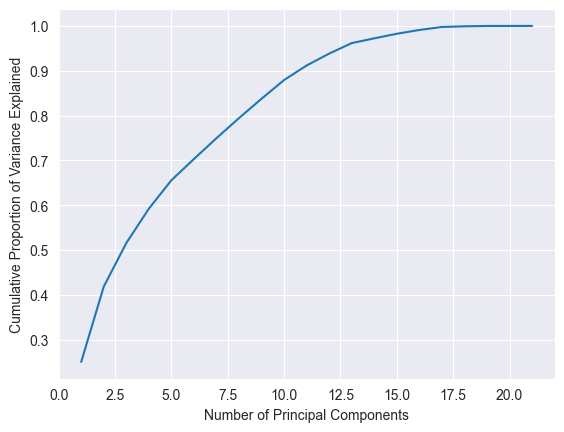

In [89]:
sns.lineplot(np.arange(1,Xtrain.shape[1]), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Proportion of Variance Explained")

C:\Users\chance.gunter\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Cumulative Proportion of Variance Explained')

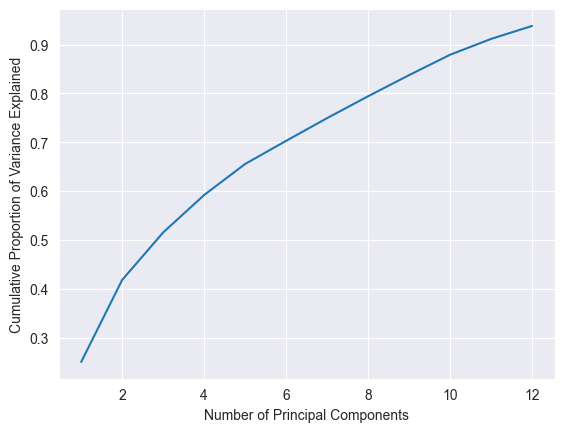

In [90]:
pca = PCA(n_components=12).fit(Xtrain)
pc_train = pca.transform(Xtrain)
sns.lineplot(np.arange(1,13), np.cumsum(pca.explained_variance_ratio_)[:12])
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Proportion of Variance Explained")

In [91]:

pc_log_reg = LogisticRegression().fit(pc_train[:,:12],ytrain.iloc[:])
pc_test = pca.transform(test_df.iloc[:,:-1])
pc_log_reg.score(pc_test[:,:12], test_df.iloc[:,22])

C:\Users\chance.gunter\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8367129135538954

In [92]:
ridgecv = RidgeCV(alphas=10**10, scoring='neg_mean_squared_error')
ridgecv.fit(Xtrain, ytrain)

RidgeCV(alphas=10000000000, scoring='neg_mean_squared_error')

In [15]:
def processSubset(X, y, predictor_variables, response_variable):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(predictor_variables)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(predictor_variables)]) - y[response_variable]) ** 2).sum()
    return {"model":regr, "RSS":RSS}


def getBest(X, y, k, response_variable):
    t0 = time.time()
    results = []

    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(X, y, combo, response_variable))

    models = pd.DataFrame(results)

    best_model = models.loc[models['RSS'].argmin()]
    t1 = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (t1-t0), "seconds.")

    return best_model

models_best = pd.DataFrame(columns=["RSS", "model"])

t2 = time.time()
for i in range(1,int(Xtrain.shape[1]) + 1):
    models_best.loc[i] = getBest(Xtrain, ytrain, i, 'hazardous')

t3 = time.time()
print("Total elapsed time:", (t3-t2), "seconds.")

Processed 100947 models on 6 predictors in 1081.3309876918793 seconds.


MemoryError: Unable to allocate 234. KiB for an array with shape (3750, 8) and data type float64

Processed 23 models on 1 predictors in 0.046914100646972656 seconds.
Processed 253 models on 2 predictors in 0.40836405754089355 seconds.
Processed 1771 models on 3 predictors in 3.898557662963867 seconds.
Processed 8855 models on 4 predictors in 20.269127368927002 seconds.
Processed 33649 models on 5 predictors in 127.85325717926025 seconds.
